<a href="https://colab.research.google.com/github/newton143/Business_Forecasting_Project/blob/main/Final_ds_lab5_RankBasedTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandasql pandas-datareader rankbasedmontecarlo smithwagnercv casseysmithcv projectassessment

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=53006bb9bbf21920515e5e4a4814da50a544e91ba5a3ab7051ba988be66d20dd
  Stored in directory: /root/.cache/pip/wheels/15/a1/e7/6f92f295b5272ae5c02365e6b8fa19cb93f16a537090a1cf27
Successfully built pandasql


In [28]:
import pandas as pd
import numpy as np
import sqlite3
from scipy.stats import percentileofscore, mannwhitneyu, ks_2samp
from scipy import optimize
import itertools
from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_columns', 10)

In [4]:
# Connection Data DB
conn = sqlite3.connect('/content/sample_data/industryFood.db')

# Test DB Connection
print(conn.cursor().execute("""
        SELECT DataYear, Gamma FROM Gamma WHERE LENGTH(IndustryCode)=6 group by DataYear;
        """).fetchall())

[(1997, -0.0064463577056763), (2002, 0.012247664796747841), (2007, 0.0025996495245163807), (2012, 0.023598968794672357)]


In [18]:
# Retrieve all Gamma values for a given year from industries with a 6-character IndustryCode.
def get_gamma_for_year(conn, year):
    query = f"""
        SELECT Gamma
        FROM Gamma
        WHERE LENGTH(IndustryCode) = 6
        AND DataYear = {year};
    """
    df = pd.read_sql_query(query, conn)
    result = df['Gamma'].tolist()
    return result

In [19]:
# Compute the Mann–Whitney U statistic (rank-based test)
def compute_mann_whitney(sample1, sample2):
    U_stat, _ = mannwhitneyu(sample1, sample2, alternative='two-sided')
    return U_stat

In [20]:
# Generate one random Mann–Whitney U value by shuffling group labels to simulate the null distribution.
def random_mann_whitney(n1, n2):
    # Create an array of labels (1s and 2s)
    groups = np.array([1] * n1 + [2] * n2)
    np.random.shuffle(groups)

    # Assign ranks 1..N and compute U statistic
    ranks = np.arange(1, n1 + n2 + 1)
    df = pd.DataFrame({'Group': groups, 'Rank': ranks})

    U1 = df.loc[df['Group'] == 1, 'Rank'].sum() - n1 * (n1 + 1) / 2
    U2 = n1 * n2 - U1
    return min(U1, U2)

In [21]:
# Run Mann–Whitney test between two years and estimate p-value using bootstrap simulation.
def run_mann_whitney_test(conn, year1, year2):
    # Get Gamma data for each year
    s1 = get_gamma_for_year(conn, year1)
    s2 = get_gamma_for_year(conn, year2)

    # Observed Mann–Whitney statistic
    observed_U = compute_mann_whitney(s1, s2)

    # Generate random U statistics (simulate 10,000 null samples)
    random_Us = np.array([random_mann_whitney(len(s1), len(s2)) for _ in range(10000)])

    # Percentile-based p-value
    p_value = percentileofscore(random_Us, observed_U) / 100
    return p_value

In [22]:
# Kolmogorov–Smirnov D-statistic: the maximum distance between two cumulative distributions.
def compute_ks_statistic(sample1, sample2):
    D_stat, _ = ks_2samp(sample1, sample2)
    return D_stat

In [23]:
# Generate one random KS statistic using bootstrapping.
def random_ks_statistic(sample1, sample2):
    combined = sample1 + sample2
    n1, n2 = len(sample1), len(sample2)
    resample1 = list(np.random.choice(combined, n1, replace=True))
    resample2 = list(np.random.choice(combined, n2, replace=True))
    D_stat, _ = ks_2samp(resample1, resample2)
    return D_stat

In [24]:
# Perform Kolmogorov–Smirnov test (using built-in analytical p-value) and Returns the p-value.
def run_ks_estimated_test(conn, year1, year2):
    s1 = get_gamma_for_year(conn, year1)
    s2 = get_gamma_for_year(conn, year2)
    _, p_value = ks_2samp(s1, s2)
    return p_value

In [25]:
# Perform bootstrap KS test by resampling to estimate the empirical p-value.
def run_ks_bootstrap_test(conn, year1, year2):
    s1 = get_gamma_for_year(conn, year1)
    s2 = get_gamma_for_year(conn, year2)
    observed_D = compute_ks_statistic(s1, s2)

    # Simulate 10,000 KS statistics under null hypothesis
    random_Ds = np.array([random_ks_statistic(s1, s2) for _ in range(10000)])

    # Empirical (bootstrap) p-value
    p_value = 1 - percentileofscore(random_Ds, observed_D) / 100
    return p_value

In [16]:
#  Runs all rank-based tests (Mann–Whitney and KS) for a given pair of years.
def analyze_year_pair(conn, year_pair):
    year1, year2 = year_pair
    mw_p = run_mann_whitney_test(conn, year1, year2)
    ks_est_p = run_ks_estimated_test(conn, year1, year2)
    ks_boot_p = run_ks_bootstrap_test(conn, year1, year2)
    result = [year1, year2, mw_p, ks_est_p, ks_boot_p]
    return result

In [26]:
# Compare Gamma values across multiple Census years using rank-based statistical tests.

# Years of interest
years = [1997, 2002, 2007, 2012]
year_pairs = list(itertools.combinations(years, 2))  # all pairwise combinations

# Run tests for all year pairs
results = [analyze_year_pair(conn, pair) for pair in year_pairs]

# Store results in DataFrame
results_df = pd.DataFrame(results, columns=[
    'Year One',
    'Year Two',
    'Mann–Whitney P-Value',
    'KS Analytical P-Value',
    'KS Bootstrap P-Value'
])

print("\n=== Rank-Based Test Results ===")
print(results_df)

# Close DB connection
conn.close()


=== Rank-Based Test Results ===
   Year One  Year Two  Mann–Whitney P-Value  KS Analytical P-Value  \
0      1997      2002                1.0000               0.996431   
1      1997      2007                1.0000               0.508335   
2      1997      2012                0.7798               0.453465   
3      2002      2007                1.0000               0.843911   
4      2002      2012                0.6084               0.683354   
5      2007      2012                0.4286               0.559322   

   KS Bootstrap P-Value  
0               0.96475  
1               0.39640  
2               0.42045  
3               0.72300  
4               0.63670  
5               0.52365  


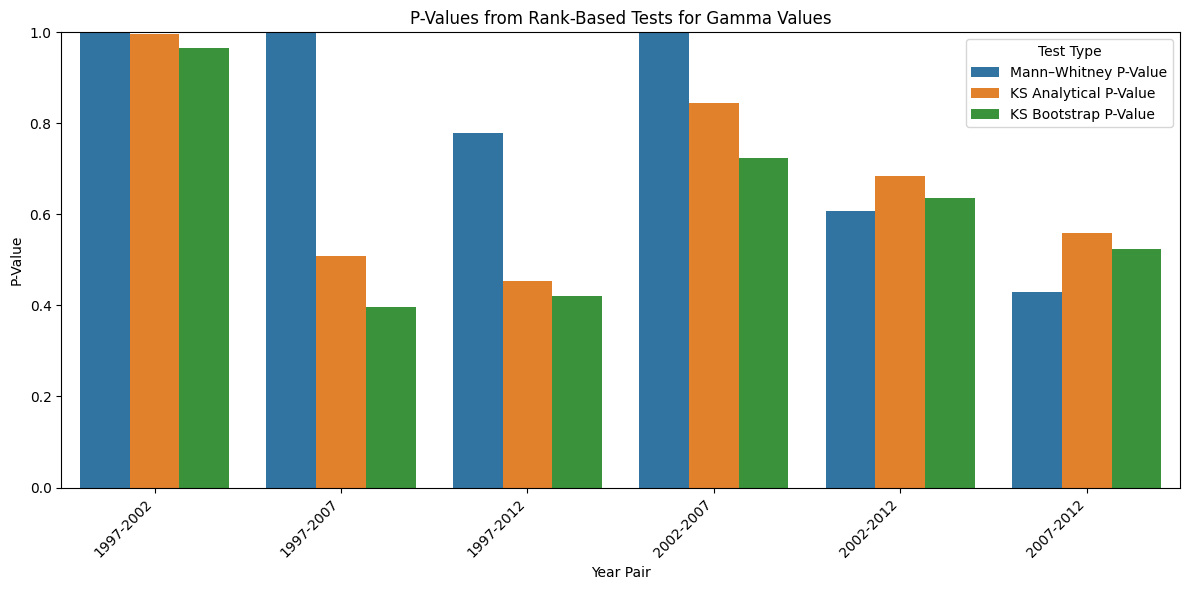

In [27]:
# Melt the DataFrame to long format for plotting
df_melted = results_df.melt(
    id_vars=['Year One', 'Year Two'],
    var_name='Test',
    value_name='P-Value'
)

# Create a combined 'Year Pair' column for the x-axis
df_melted['Year Pair'] = df_melted['Year One'].astype(str) + '-' + df_melted['Year Two'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Year Pair', y='P-Value', hue='Test', data=df_melted)
plt.title('P-Values from Rank-Based Tests for Gamma Values')
plt.ylabel('P-Value')
plt.xlabel('Year Pair')
plt.ylim(0, 1) # P-values are between 0 and 1
plt.xticks(rotation=45, ha='right')
plt.legend(title='Test Type')
plt.tight_layout()
plt.show()